# Customer Churn Prediction — End-to-End Workflow

This notebook covers the full pipeline:
1. Data loading and cleaning
2. Exploratory data analysis (EDA)
3. Feature encoding and train/test split
4. Model training (Logistic Regression and CHAID-style Decision Tree)
5. Evaluation (metrics, ROC, gains, lift)
6. Model selection and saving
7. Prediction demo on new data


In [1]:
# Imports and setup
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Add src to path
sys.path.append('../src')

from preprocess import load_data, clean_data, get_data_summary, encode_categorical_variables, prepare_data
from train import train_models, save_model
from evaluate import evaluate_models
from predict_churn import predict_churn

DATA_PATH = '../data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
VIS_DIR = '../reports/visuals'
MODEL_DIR = '../models'
os.makedirs(VIS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print('Environment ready.')


Environment ready.


### Environment/setup confirmation
- The message confirms that required libraries loaded, plotting style set, and project paths (e.g., `src`) are available.
- Directories for visuals and models are created if missing; outputs later in the notebook will save there.


In [2]:
# 1) Data loading and cleaning

df_raw = load_data(DATA_PATH)
df = clean_data(df_raw)

print(f"Shape after cleaning: {df.shape}")
print("Columns:", list(df.columns))

df.head()


Dataset loaded successfully. Shape: (7043, 21)
Found 11 missing values in TotalCharges
Missing values filled with 0
Shape after cleaning: (7043, 20)
Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Understanding the cleaned dataset preview
- **Shape after cleaning**: Confirms rows/columns used downstream; matches later `prepare_data` step.
- **Missing values handling**: `TotalCharges` gaps filled (0) and `customerID` dropped to avoid leakage and non-informative ID.
- **`head()`**: Quick sanity check on types and expected columns before modeling.


Overall churn rate: 26.54%


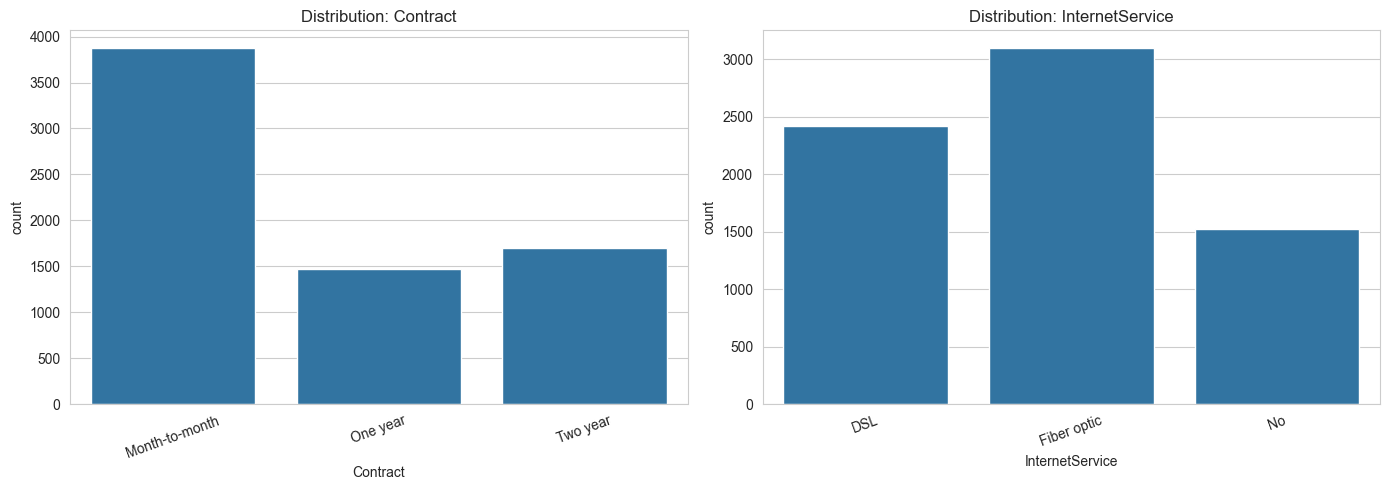

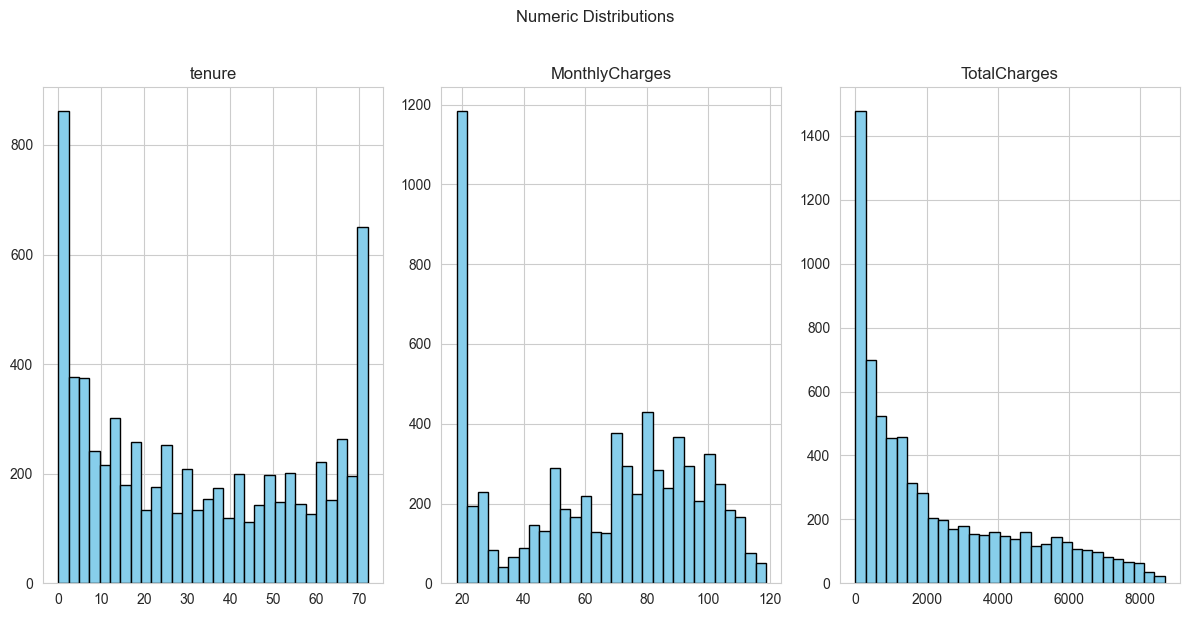

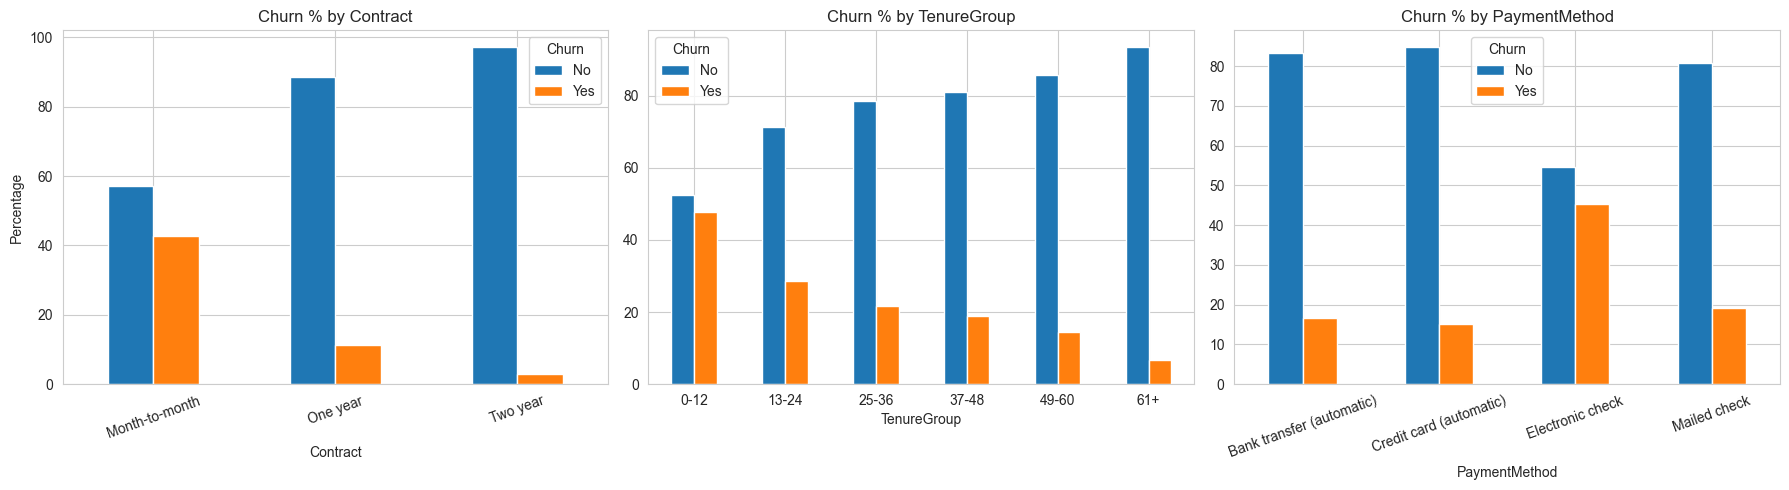

In [3]:
# 2) Quick EDA

# Overall churn rate
overall_churn = (df['Churn'] == 'Yes').mean() * 100
print(f"Overall churn rate: {overall_churn:.2f}%")

# Top categorical distributions (example: Contract, InternetService)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(data=df, x='Contract', ax=axes[0])
axes[0].set_title('Distribution: Contract')
axes[0].tick_params(axis='x', rotation=20)

sns.countplot(data=df, x='InternetService', ax=axes[1])
axes[1].set_title('Distribution: InternetService')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

# Numeric histograms
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols].hist(bins=30, figsize=(12, 6), layout=(1, 3), color='skyblue', edgecolor='black')
plt.suptitle('Numeric Distributions', y=1.02)
plt.tight_layout()
plt.show()

# Churn rate by key groups
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

churn_contract = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
churn_contract.plot(kind='bar', ax=axes[0], title='Churn % by Contract')
axes[0].set_ylabel('Percentage')
axes[0].tick_params(axis='x', rotation=20)

# Tenure bands
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0,12,24,36,48,60,72], labels=['0-12','13-24','25-36','37-48','49-60','61+'])
churn_tenure = pd.crosstab(df['TenureGroup'], df['Churn'], normalize='index') * 100
churn_tenure.plot(kind='bar', ax=axes[1], title='Churn % by TenureGroup')
axes[1].tick_params(axis='x', rotation=0)

churn_payment = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100
churn_payment.plot(kind='bar', ax=axes[2], title='Churn % by PaymentMethod')
axes[2].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()


### Interpreting the EDA outputs
- **Overall churn rate**: Baseline proportion of churners; use as a reference for lift.
- **Categorical distributions**: Contract type and internet service mix explain much of churn variability (e.g., Month-to-month tends to churn more).
- **Numeric distributions**: Tenure is right-skewed; lower tenure segments often show higher churn.
- **Churn by groups**: Bar charts show which segments have higher churn %. Use this to prioritize retention focus (e.g., early-tenure, fiber-optic, electronic check).


In [4]:
# 3) Encoding and train/test split (via prepare_data + train)

# Prepare encoded features and labels
X, y, feature_names, encoders, df_clean = prepare_data(DATA_PATH)

# Train both models and keep splits
results = train_models(X, y, feature_names)

# Unpack for convenience
lr_model = results['lr_model']
chaid_model = results['chaid_model']
X_test = results['X_test']
y_test = results['y_test']


Dataset loaded successfully. Shape: (7043, 21)
Found 11 missing values in TotalCharges
Missing values filled with 0

=== Dataset Summary ===
Shape: (7043, 20)

Missing Values:
{'gender': 0, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0, 'tenure': 0, 'PhoneService': 0, 'MultipleLines': 0, 'InternetService': 0, 'OnlineSecurity': 0, 'OnlineBackup': 0, 'DeviceProtection': 0, 'TechSupport': 0, 'StreamingTV': 0, 'StreamingMovies': 0, 'Contract': 0, 'PaperlessBilling': 0, 'PaymentMethod': 0, 'MonthlyCharges': 0, 'TotalCharges': 0, 'Churn': 0}
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Total features after encoding: 30
Train set: 5634 samples
Test set: 1409 samples

=== Training Logistic Regressi

### What the training logs and rules mean
- **Encoding and splits**: Categorical variables are one-hot encoded; data is split into train/test to evaluate generalization.
- **Models trained**: Logistic Regression (probabilistic, linear) and a CHAID-style Decision Tree (rule-based, interpretable).
- **Top rules**: The listed conditions indicate segments with higher churn risk (e.g., short tenure + fiber optics + certain charge ranges). Use these as actionable business insights for segment-specific retention tactics.



MODEL EVALUATION

=== Logistic Regression Metrics ===
Accuracy:  0.8048
Precision: 0.6542
Recall:    0.5615
F1-Score:  0.6043
ROC-AUC:   0.8427
Lift (Top Decile): 2.86

=== CHAID Decision Tree Metrics ===
Accuracy:  0.7956
Precision: 0.6335
Recall:    0.5455
F1-Score:  0.5862
ROC-AUC:   0.8268
Lift (Top Decile): 2.81

=== Model Comparison Table ===
              Model  Accuracy  ROC-AUC     Lift                               Best Use Case
Logistic Regression  0.804826 0.842729 2.858934 General purpose, interpretable coefficients
CHAID Decision Tree  0.795600 0.826792 2.805496 Rule-based decisions, high interpretability
ROC curve saved to ../reports/visuals\roc_curves.png


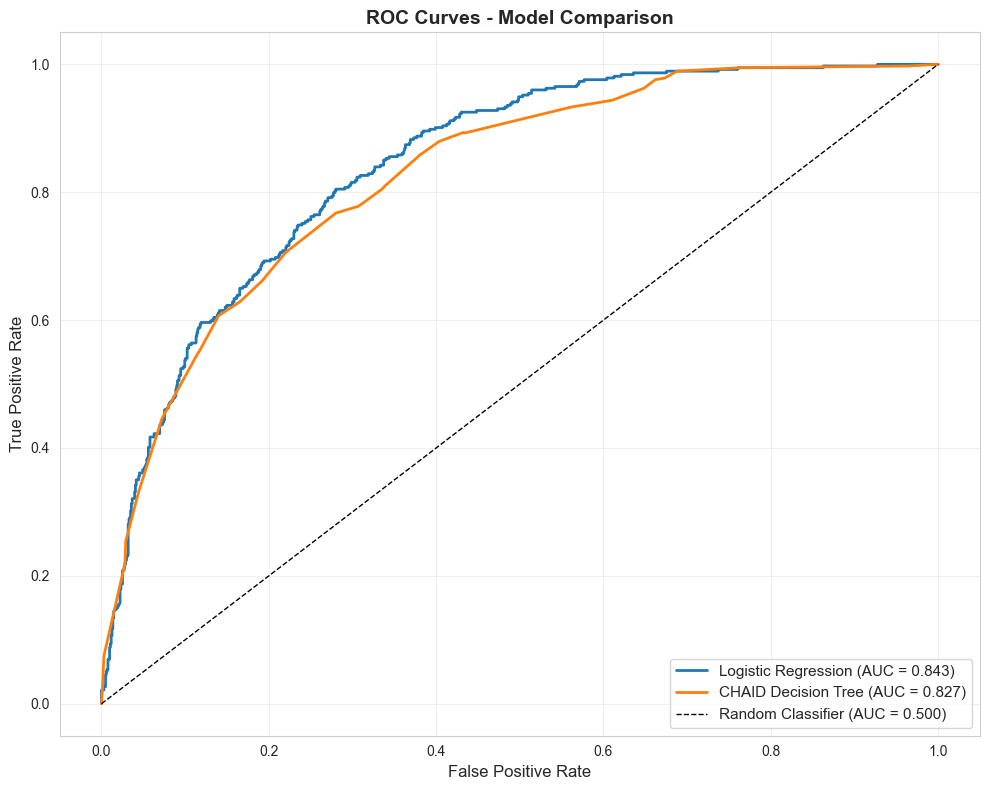

Gains chart saved to ../reports/visuals\gains_chart.png


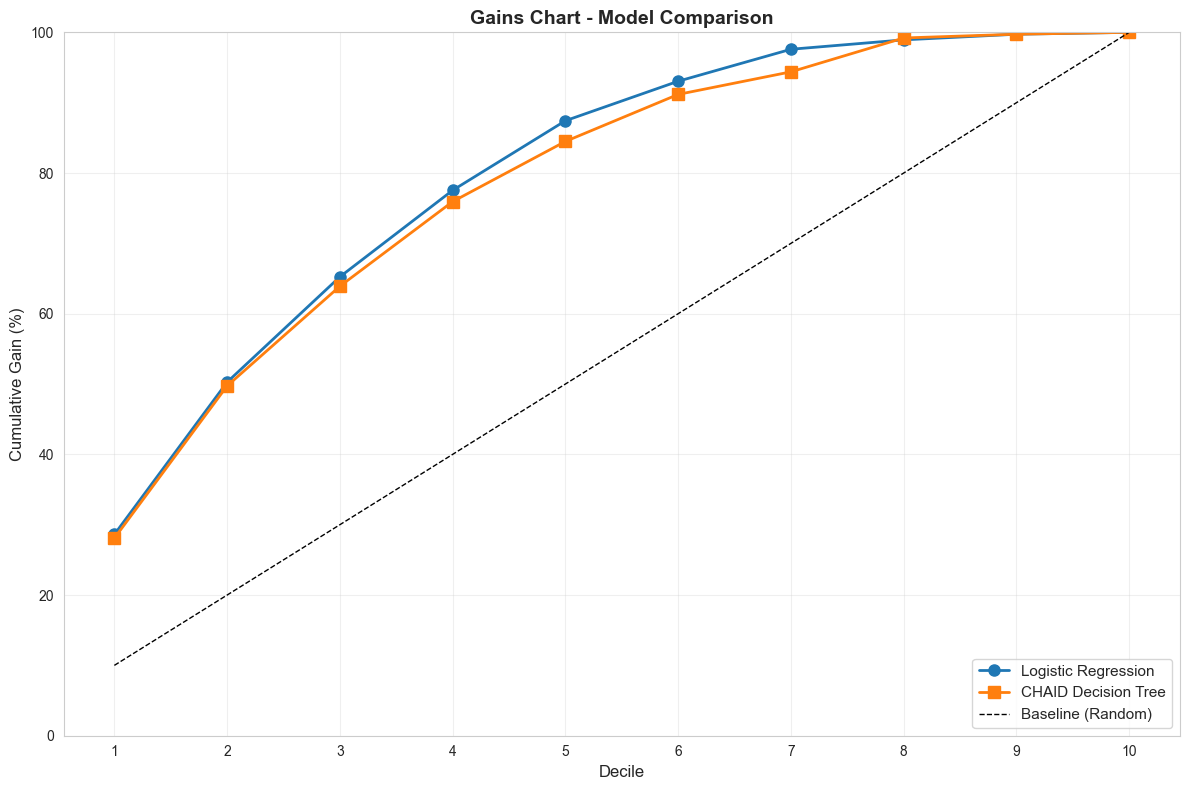

Lift chart saved to ../reports/visuals\lift_chart.png


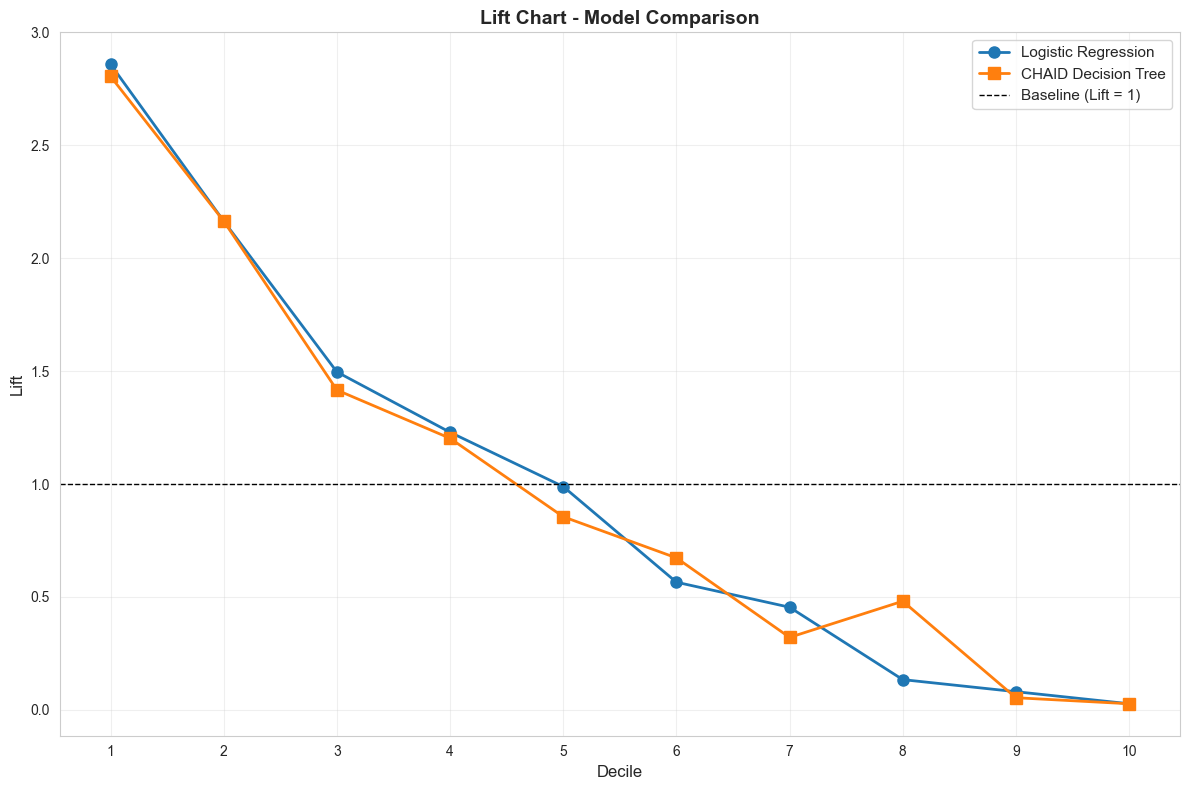


=== Gains and Lift Analysis (Top 3 Deciles) ===

Logistic Regression:
 decile  total_customers  churn_customers      gain     lift
      1              141              107 28.609626 2.858934
      2              141               81 50.267380 2.164239
      3              141               56 65.240642 1.496264

CHAID Decision Tree:
 decile  total_customers  churn_customers      gain     lift
      1              141              105 28.074866 2.805496
      2              141               81 49.732620 2.164239
      3              141               53 63.903743 1.416107


,Model,Accuracy,ROC-AUC,Lift,Best Use Case
0,Logistic Regression,0.804826,0.842729,2.858934,"General purpose, interpretable coefficients"
1,CHAID Decision Tree,0.795600,0.826792,2.805496,"Rule-based decisions, high interpretability"


In [5]:
# 4) Evaluation: metrics, ROC, gains, lift
comparison_df, gains_lift_lr, gains_lift_tree = evaluate_models(
    lr_model, chaid_model, X_test, y_test, feature_names, save_dir=VIS_DIR
)

comparison_df


### How to read the evaluation results
- **Metrics table**: Compare **Accuracy**, **Precision**, **Recall**, **F1**, and **ROC-AUC**. AUC reflects ranking quality; use it for model selection. Precision/Recall trade off with threshold.
- **Lift (Top Decile)**: Customers in the top 10% by score are ~Lift times more likely to churn than average. Higher is better for targeted retention.
- **Saved charts**: ROC, Gains, and Lift charts are saved under `reports/visuals`. Use Gains/Lift to estimate how many churners you capture by focusing on top deciles.


In [6]:
# 5) Model selection and saving (best by ROC-AUC)
from sklearn.metrics import roc_auc_score

proba_lr = lr_model.predict_proba(X_test)[:, 1]
proba_tree = chaid_model.predict_proba(X_test)[:, 1]

auc_lr = roc_auc_score(y_test, proba_lr)
auc_tree = roc_auc_score(y_test, proba_tree)

best_model = lr_model if auc_lr >= auc_tree else chaid_model
best_name = 'Logistic Regression' if auc_lr >= auc_tree else 'CHAID Decision Tree'
print(f"Best model: {best_name} (AUC = {max(auc_lr, auc_tree):.4f})")

# Save best model with encoders and feature names
import joblib
model_bundle = {
    'model': best_model,
    'encoders': encoders,
    'feature_names': feature_names,
    'model_name': best_name
}

best_path = os.path.join(MODEL_DIR, 'churn_model.joblib')
joblib.dump(model_bundle, best_path)
print(f"Saved best model to {best_path}")


Best model: Logistic Regression (AUC = 0.8427)
Saved best model to ../models\churn_model.joblib


### Why this model was selected and saved
- We compared models using **ROC-AUC** on the held-out test set and chose the one with the higher AUC as the best general discriminator across thresholds.
- The saved bundle includes the trained model, feature names, and encoders so that the same preprocessing pipeline is applied at inference time.
- The file is written to `models/churn_model.joblib`, enabling reproducible scoring in other scripts or services.


In [7]:
# 6) Prediction demo on new data

example_customer = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 5,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 95.3,
    'TotalCharges': 350.0
}

pred = predict_churn(example_customer, model_path=best_path, return_proba=True)
pred[['Churn_Prediction', 'Churn_Probability', 'Churn_Risk']]


,Churn_Prediction,Churn_Probability,Churn_Risk
0,Yes,0.765436,High


### What this prediction shows
- **Churn_Prediction**: Final yes/no decision after applying the best model and 0.5 threshold.
- **Churn_Probability**: Model’s estimated probability that the customer will churn (0–1). Use this for ranking customers by risk.
- **Churn_Risk**: A human-friendly band derived from probability (e.g., Low/Medium/High) to support targeting strategies.

Tip: To action this, sort customers by probability and focus retention offers on the top deciles first (see Gains/Lift results).


## Summary
- Data cleaned (handled `TotalCharges`, removed `customerID`).
- EDA confirms higher churn in: month-to-month contracts, early tenure, electronic check users.
- Trained Logistic Regression and CHAID-style decision tree; evaluated with ROC, gains, lift.
- Selected and saved best model by AUC to `models/churn_model.joblib`.
- Demonstrated prediction on a sample customer with probability and risk band.
